In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.spatial import distance
import pathlib
import os
from sklearn.decomposition import PCA
import json
import random
from random import sample

random.seed(30)

In [3]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [4]:
#load the cell counts from the supplmental_6
counts = pd.read_csv('../CP/single_cell_profiles/outputs/HeLa_SABER_screen_CP_arm_cell_count.csv.gz')

#load barcodes used in experiment
saber_library = pd.read_csv("SABER_Library_ngt_Included_Oligo_Sequences_Assiged.csv")
guide_list = list(saber_library['sgRNA'])

# Import the guide-level profiles
df_guide = pd.read_csv("outputs/20240202_6W_CP498_SABER_Pilot_HeLa_guide_normalized_merged_feature_select_median_ALLWELLS_cp.csv.gz")

# Load p_values from the hit calling process
df_p_values = pd.read_csv('outputs/HeLa_CP_significant_features_mann_whitney_p_values_cp_features.csv.gz')
df_p_values = df_p_values.set_index('Gene')
    
# Load hits from the hit calling process
whole_cell_hits = pd.read_csv('outputs/HeLa_CP_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv')
comp_spec_hits = pd.read_csv('outputs/HeLa_CP_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv')
all_hits = pd.concat([whole_cell_hits,comp_spec_hits])
hit_list = list(comp_spec_hits.Gene) + list(whole_cell_hits.Gene)
df_guide_hits = df_guide[df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
df_guide_cell_hits = df_guide[df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(list(whole_cell_hits.Gene))]
df_guide_cell_hits

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,Cells_AreaShape_CentralMoment_2_1,...,Nuclei_Texture_InfoMeas1_Mito_5_01_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_WGA_10_00_256,Nuclei_Texture_InfoMeas1_WGA_5_00_256,Nuclei_Texture_InfoMeas1_WGA_5_02_256,Nuclei_Texture_InfoMeas2_DAPI_Painting_10_03_256,Nuclei_Texture_InfoMeas2_Mito_5_02_256,Nuclei_Texture_InfoMeas2_Phalloidin_5_00_256,Nuclei_Texture_SumAverage_DAPI_Painting_10_03_256,Nuclei_Texture_SumVariance_Mito_10_03_256
16,ACTR2,AAACACATTGTGCTTTCTGG,0.969470,-1.071650,0.544435,0.150210,-0.193674,-0.074405,-0.076582,-0.217265,...,-3.236250,-2.898150,-3.208250,-2.342015,-2.585850,1.784400,2.934050,2.635950,2.460650,3.228100
17,ACTR2,ATCCTCGCAACAGAAGTAGC,-0.025455,0.997230,0.396103,0.684165,-0.697935,0.371270,0.133150,-0.154340,...,-0.509715,-0.453250,-0.488165,-0.333950,-0.390222,0.608545,0.659385,0.420200,1.152200,0.528875
18,ACTR2,GGACGTATCATCAAAGTTGG,-0.932135,-1.057560,0.001650,0.249254,0.018745,0.007075,0.008096,-0.451241,...,-4.839550,-4.643450,-4.594050,-4.275750,-3.417000,2.193550,4.268850,4.614450,2.943250,7.109650
19,ACTR2,GGTGTGCGACAACGGCACCG,-0.748115,0.902140,0.105253,-0.070435,-0.418315,0.030160,-0.139054,0.165882,...,-5.767950,-5.406900,-5.386700,-4.287200,-4.228300,2.184700,4.847050,5.115650,2.834050,7.692850
20,ACTR3,ACCGGTACGGTAATAGACAG,0.002300,0.906245,-0.197962,-0.123888,0.553190,0.146307,-0.027800,-0.226321,...,-2.497750,-2.574750,-2.870250,-2.044250,-1.412950,1.806600,2.200850,2.554550,1.779000,2.144450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,ZC3HC1,GGGTGATCCATTAACTGACT,0.700055,-0.069160,1.112795,-0.654830,-0.752710,1.119714,0.782702,0.302075,...,-0.052642,0.509320,0.393371,0.166785,0.200200,-0.178080,-0.168690,-0.137166,-0.471280,-0.031610
2356,ZNHIT6,CAATGGATTCACCAAGAGGA,0.263665,-0.278455,-0.065060,-0.532490,0.193650,-0.724703,-0.032512,-0.132660,...,-4.194200,-4.062950,-3.853500,-3.070000,-2.924350,2.499350,3.330900,3.829600,3.463400,3.987800
2357,ZNHIT6,CCTCCGATAAATCACCCGGT,0.637565,1.111000,-0.571505,-0.032475,-0.158239,0.085890,0.023116,0.007950,...,-0.478270,-0.511025,-0.577715,-0.564520,-0.222685,0.562695,0.386695,0.693180,0.295555,0.102665
2358,ZNHIT6,GACATGAAAGTTCTTCACCA,-1.029110,0.544496,-0.518000,0.091323,0.144875,-0.063470,0.181302,0.173560,...,0.080505,0.399506,0.032645,0.472010,0.230345,0.047005,-0.256095,-0.379635,-0.135998,-0.315075


In [5]:
def perform_pca(df_guide_hits):
    df_temp = df_guide_hits.copy(deep=True)
    df_temp['Gene'] = df_temp['Metadata_Foci_Barcode_MatchedTo_GeneCode'] + ' ' + df_temp['Metadata_Foci_Barcode_MatchedTo_Barcode']
    order = ['Gene']+list(df_temp.columns[:-1])
    df_temp = df_temp[order]
    df_temp = df_temp.drop(columns=['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']).set_index('Gene')
    # Perform principal component analysis on hit lists

    pca = PCA()
    pca.fit(df_temp)
    x = list(pca.explained_variance_ratio_)
    # Find principal component that represents 90% variation
    PCA_lookup = {}
    condition = 'HeLa_CP'
    for i in range(len(x)):
        distance = abs(.9-sum(x[:i+1]))
        PCA_lookup[distance] = i 
    component = PCA_lookup[min(PCA_lookup.keys())]+1
    print (f'For {condition}, principal component representing closest to 90% variation is {component}')
    # Perform principal component analysis and select components representing 90% of variation in data
    pca = PCA(n_components=component)
    df_pca = pd.DataFrame(pca.fit_transform(df_temp),index=df_temp.index)
    df_pca = df_pca.reset_index()
    df_pca[['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']] = df_pca.Gene.str.split(' ', expand = True)
    order = ['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']+list(df_pca.columns[1:-2])
    df_pca = df_pca[order]
    return df_pca

pca_cell_df = perform_pca(df_guide_cell_hits) 
pca_df = perform_pca(df_guide_hits)
pca_df

For HeLa_CP, principal component representing closest to 90% variation is 65
For HeLa_CP, principal component representing closest to 90% variation is 76


,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,0,1,2,3,4,5,6,7,...,66,67,68,69,70,71,72,73,74,75
0,ABCF1,GATGGAGTATGAGCGCCAAG,-3.604002,-14.529340,-3.215243,0.620307,3.662322,-1.386142,-11.517989,-7.638352,...,0.235119,1.806663,-0.381135,0.678116,1.064923,-0.052505,-0.281740,0.937619,-0.324903,0.239803
1,ABCF1,GCAACACATCAATGTTGGGA,-6.032174,-4.526412,-4.239300,-0.768595,-3.353236,-1.161681,-1.070162,-5.707695,...,-0.287088,0.156008,-0.139336,-0.400500,-0.241527,-0.965891,0.790669,1.087166,0.384698,0.060862
2,ABCF1,GCGGGAGGACATCTCCGCCT,-5.978887,-4.114742,-4.172640,-4.442700,3.201462,0.255349,-0.307022,-0.796048,...,1.208224,-0.418942,0.346213,-0.328941,-0.474823,-0.032219,-0.120234,-0.592728,0.025954,0.166934
3,ABCF1,TGTAATTGCCCCTATAGTAG,-8.141653,-10.353388,0.626692,5.178801,-0.535019,-2.614514,-9.528909,-10.165212,...,-1.535748,-0.283037,-1.903043,-1.532506,1.479514,0.040360,0.018065,1.233136,-1.040141,0.507269
4,ABLIM1,TAAGCAATCTACGAAGACCG,-1.337409,13.851391,-7.558253,3.803576,-4.301208,-5.057442,4.759078,0.174120,...,0.083848,0.353951,0.362626,0.083458,0.494337,-0.282951,0.731762,-0.568257,1.021678,0.503132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,ZC3HC1,GGGTGATCCATTAACTGACT,-4.787585,-3.111113,5.142352,-5.160714,6.182562,0.618378,-2.839994,0.708875,...,0.417642,-1.288921,-0.076151,0.731830,0.589476,0.365652,0.992006,-0.581252,0.669503,0.501751
1208,ZNHIT6,CAATGGATTCACCAAGAGGA,55.868886,-25.139139,0.598015,11.347519,-16.986189,-6.716949,-2.737457,1.652060,...,1.211399,0.701622,-0.978263,1.129364,-0.957224,-0.630612,2.242635,-0.723790,1.331176,-0.724103
1209,ZNHIT6,CCTCCGATAAATCACCCGGT,6.780255,-5.384418,-4.899074,0.724792,-1.148702,-1.058854,1.459353,0.631648,...,0.271258,-0.208399,-0.343405,-0.202289,0.264281,0.218548,-0.404416,-0.174360,-0.372934,0.297856
1210,ZNHIT6,GACATGAAAGTTCTTCACCA,-4.093975,-1.220129,-2.845484,-1.036489,2.283073,1.004446,0.697458,-0.706138,...,-0.693137,0.110898,0.379387,-0.544065,0.238720,-0.070113,0.224949,0.524254,0.123618,0.793748


In [6]:
# Function to calculate correleations, cluster and draw heatmap 
def heat_map(data,title,file_name,font_scale=0.8):
        corr = data.corr()
        
        plt.clf()
        
        sns.set(font_scale=font_scale,rc={'figure.figsize':(30,30)})

        ax = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap = sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
            linewidth = 0.1,
            linecolor = 'white',
            square = True,
            cbar=False,
            cbar_kws = {"shrink": .76}
        )
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=90,
            horizontalalignment='right'
        )

        ax.set_title(title,fontsize=30)
        plt.tight_layout()
        fig = ax.get_figure()
        plt.show()
        fig.savefig(os.path.join(output_folder,f'{file_name}'),dpi=300)
        

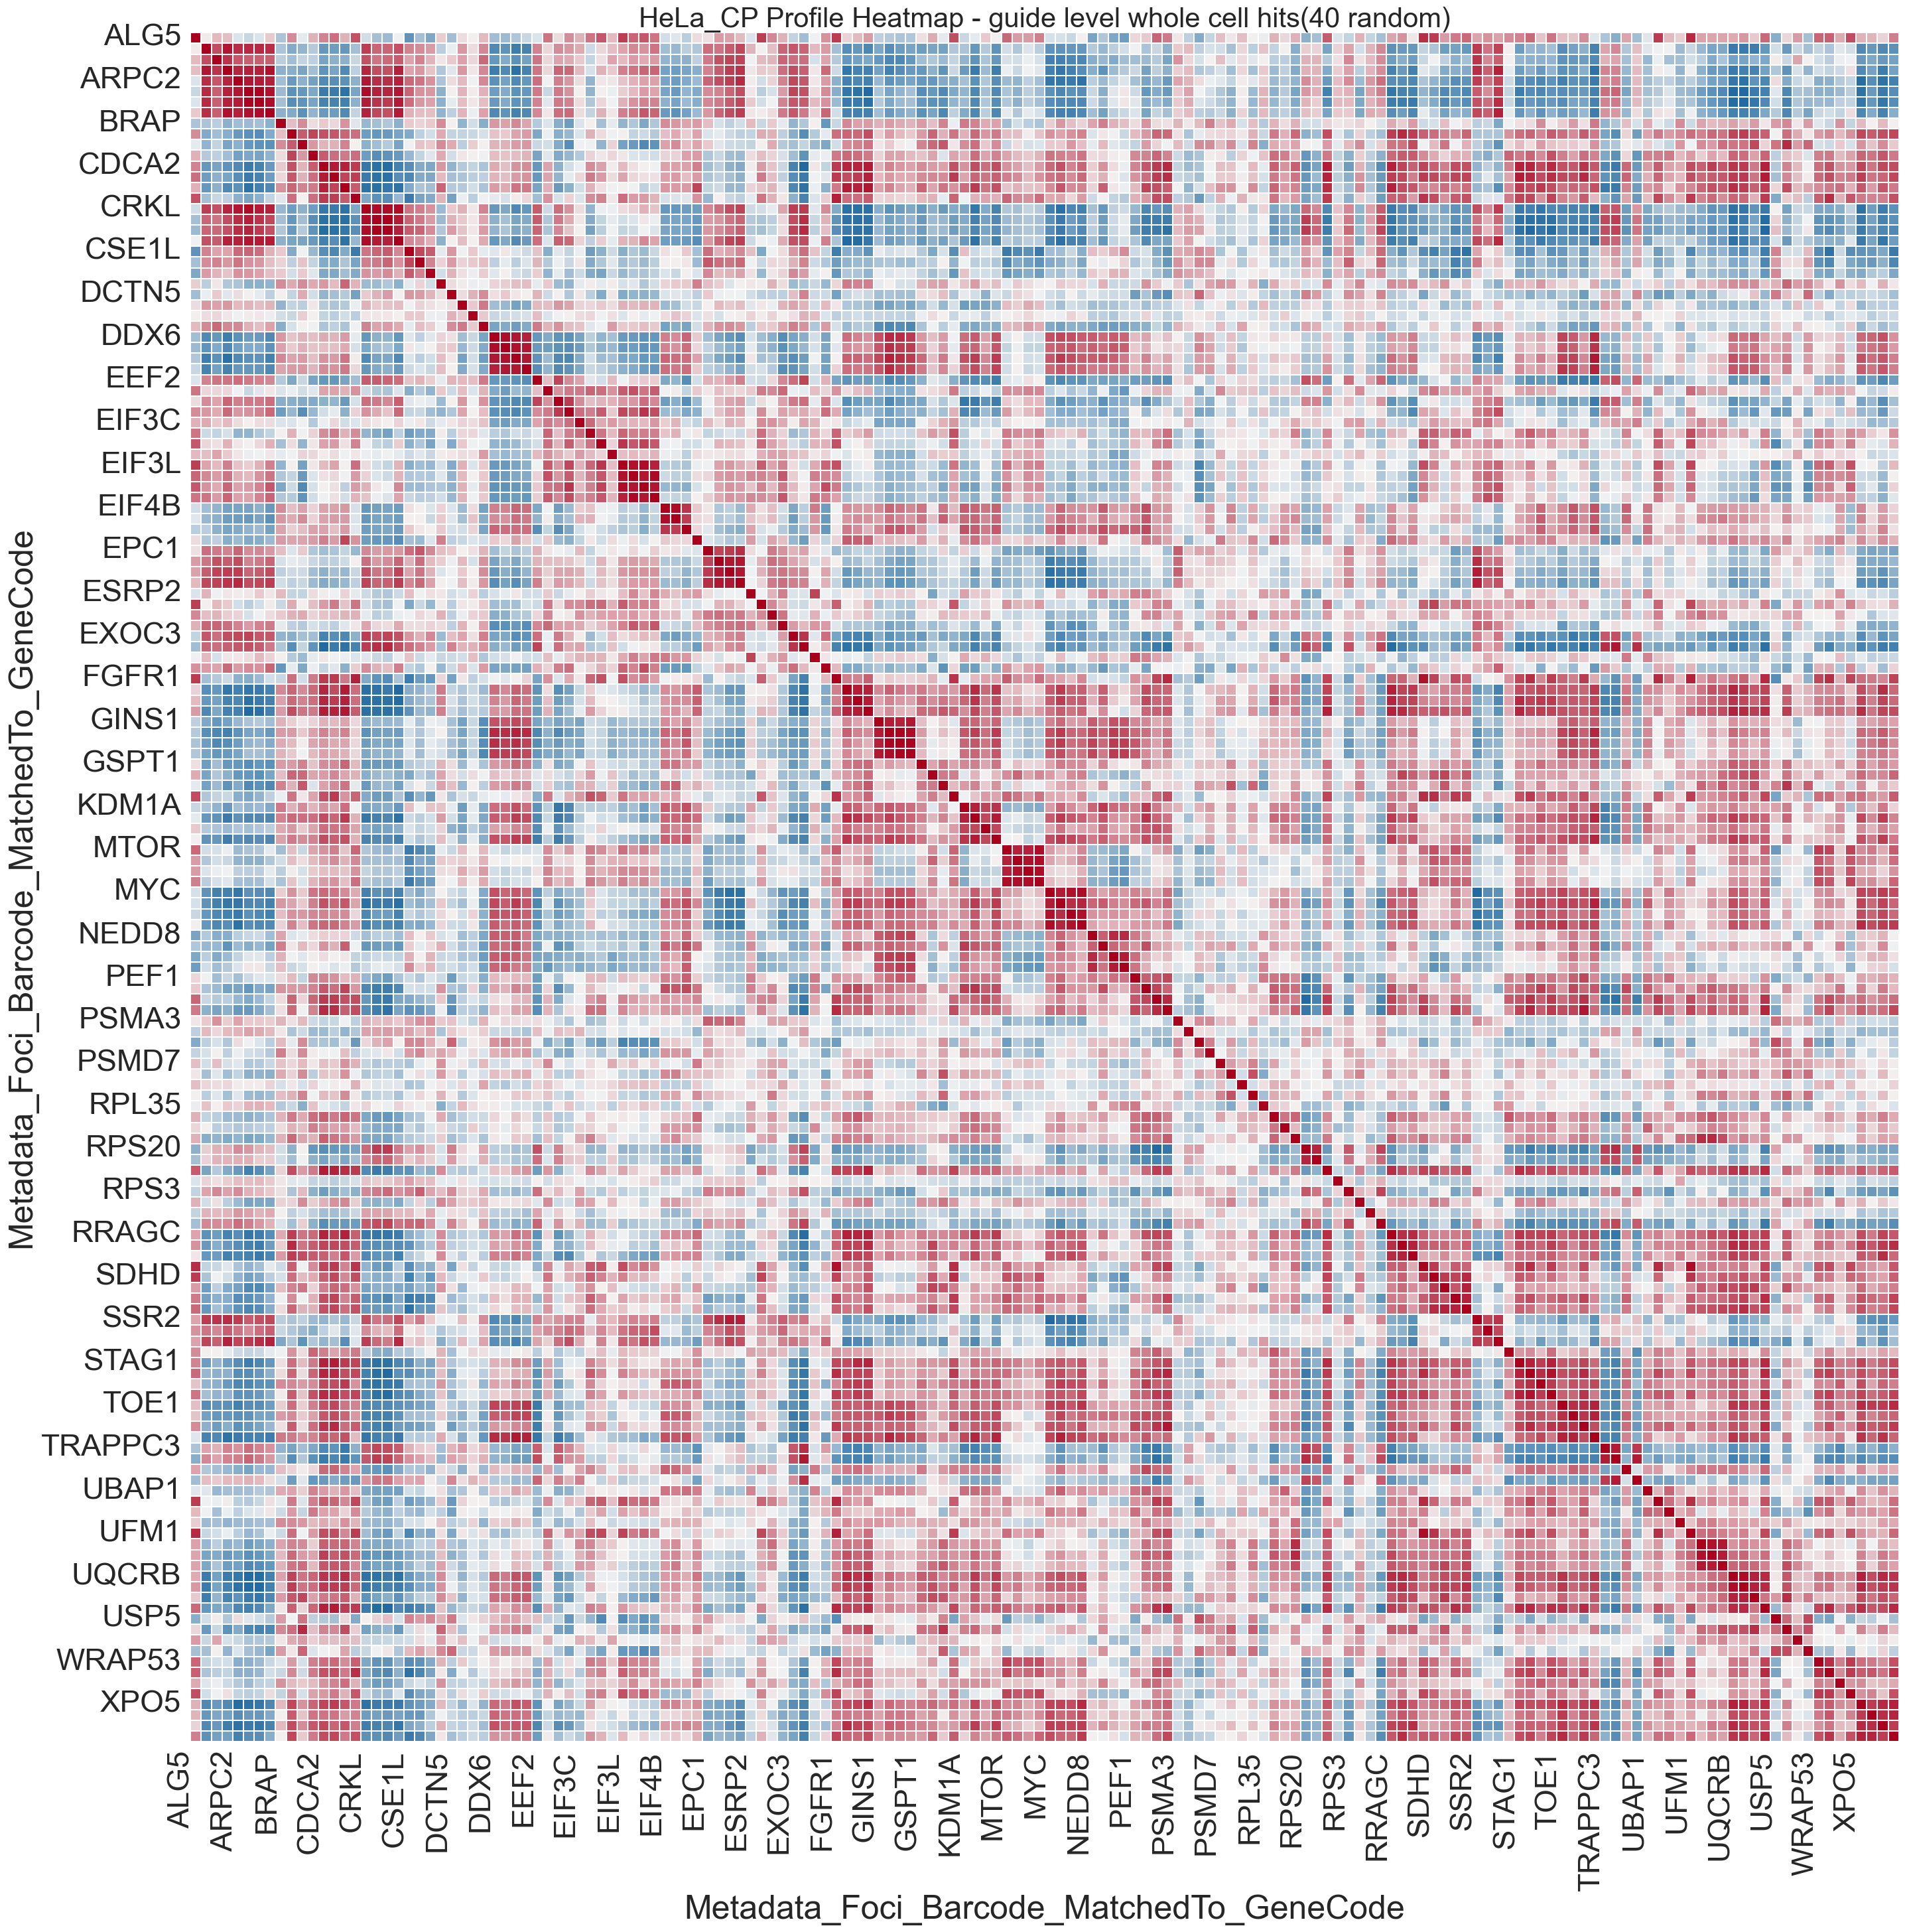

In [8]:
# Subset the data and draw heat-maps for guides with high guide count
def draw_high_count_heat_maps(hit_list, profile_df, data_set, font_scale):
    random.seed(13)
    genes_list = sample(hit_list,40)
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level whole cell hits(40 random)',
                       f'{data_set}_profile_heatmap_guide_level_whole_cell_hits_40_random.png',
                       font_scale)
    

draw_high_count_heat_maps(list(whole_cell_hits.Gene), pca_cell_df, 'HeLa_CP', 3)


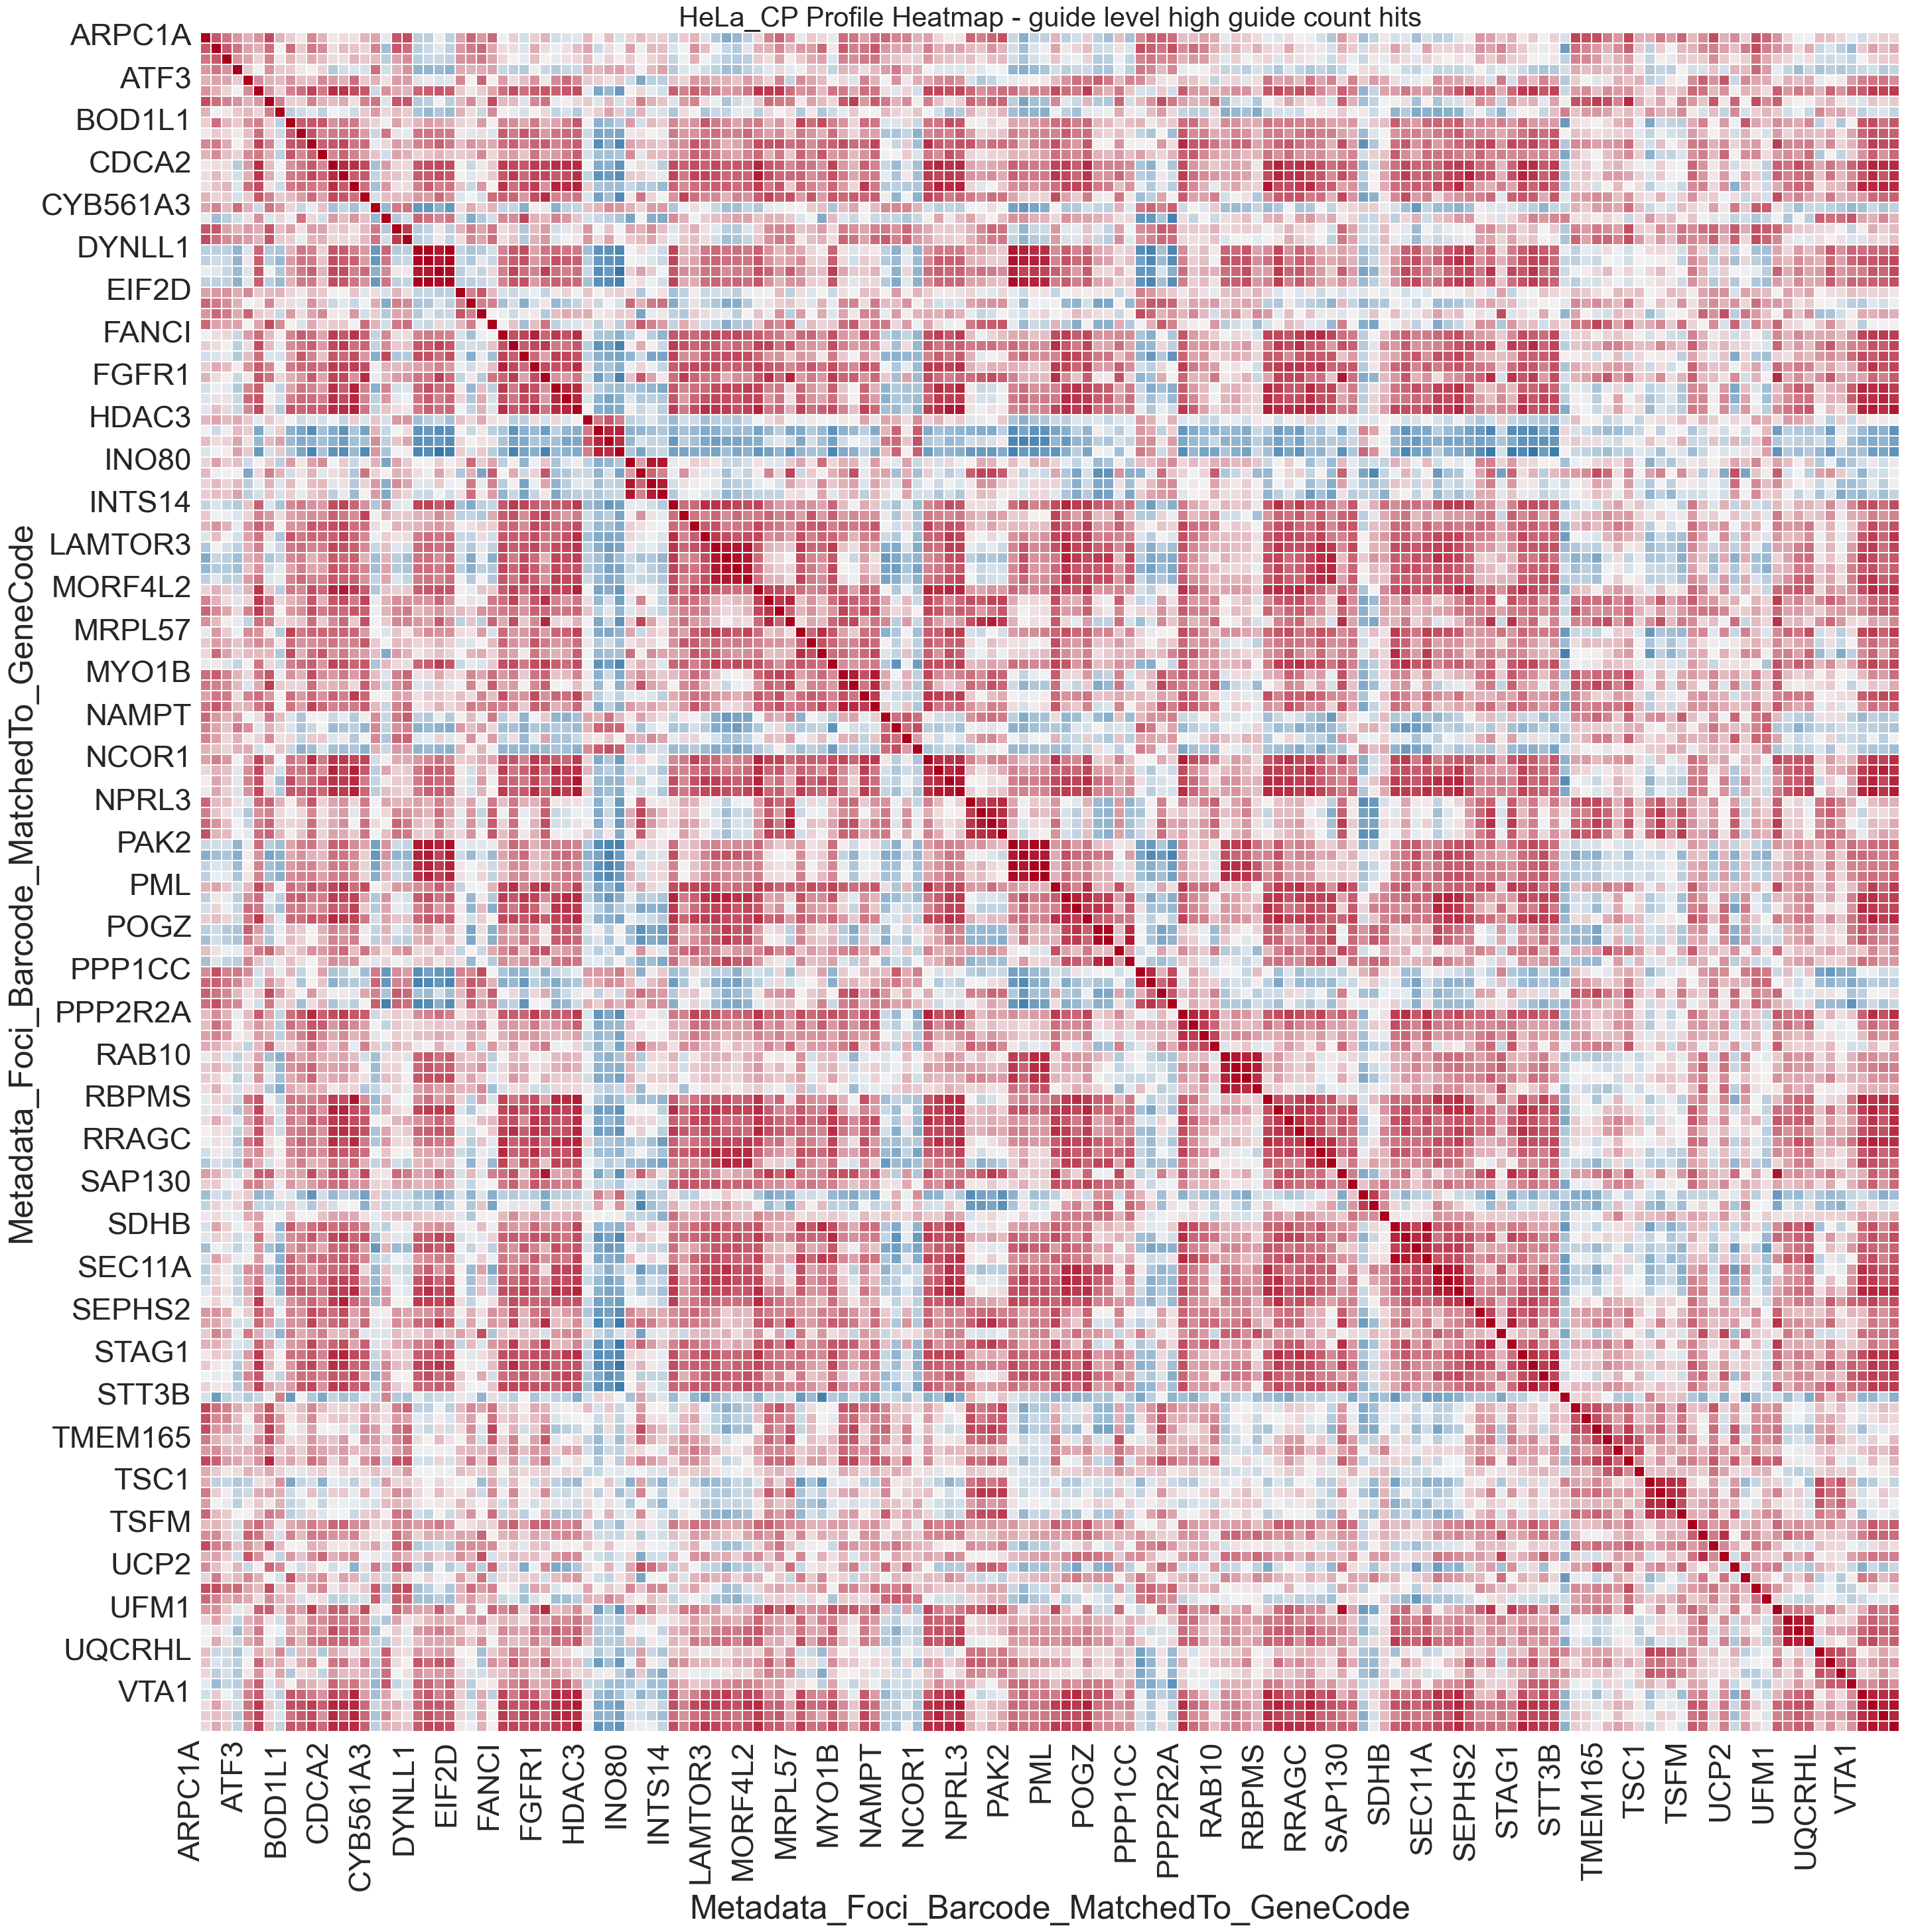

In [9]:
# find a cell count per guide to determine highly represented guides for each data set
for guide_count in range(50,1000,1): # adjust the range based on the cell count data
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
    hit_counts = hit_counts.query(f"Cell_Count > {guide_count}").groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    high_guide_list = list(hit_counts.query("Cell_Count > 3").index)
    if len(high_guide_list) <= 50:
        guide_count = guide_count-1
        break

# Subset the data and draw heat-maps for guides with high guide count
def draw_high_count_heat_maps(counts, guide_count, hit_list, profile_df, data_set, font_scale):
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
    hit_counts = hit_counts.query(f"Cell_Count > {guide_count}").groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    high_guide_list = list(hit_counts.query("Cell_Count > 3").index)
    random.seed(13)
    genes_list = sample(high_guide_list,40)
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level high guide count hits',
                       f'{data_set}_profile_heatmap_guide_level_high_guide_count_hits.png',
                       font_scale)
    

draw_high_count_heat_maps(counts, guide_count, hit_list, pca_df, 'HeLa_CP', 3)


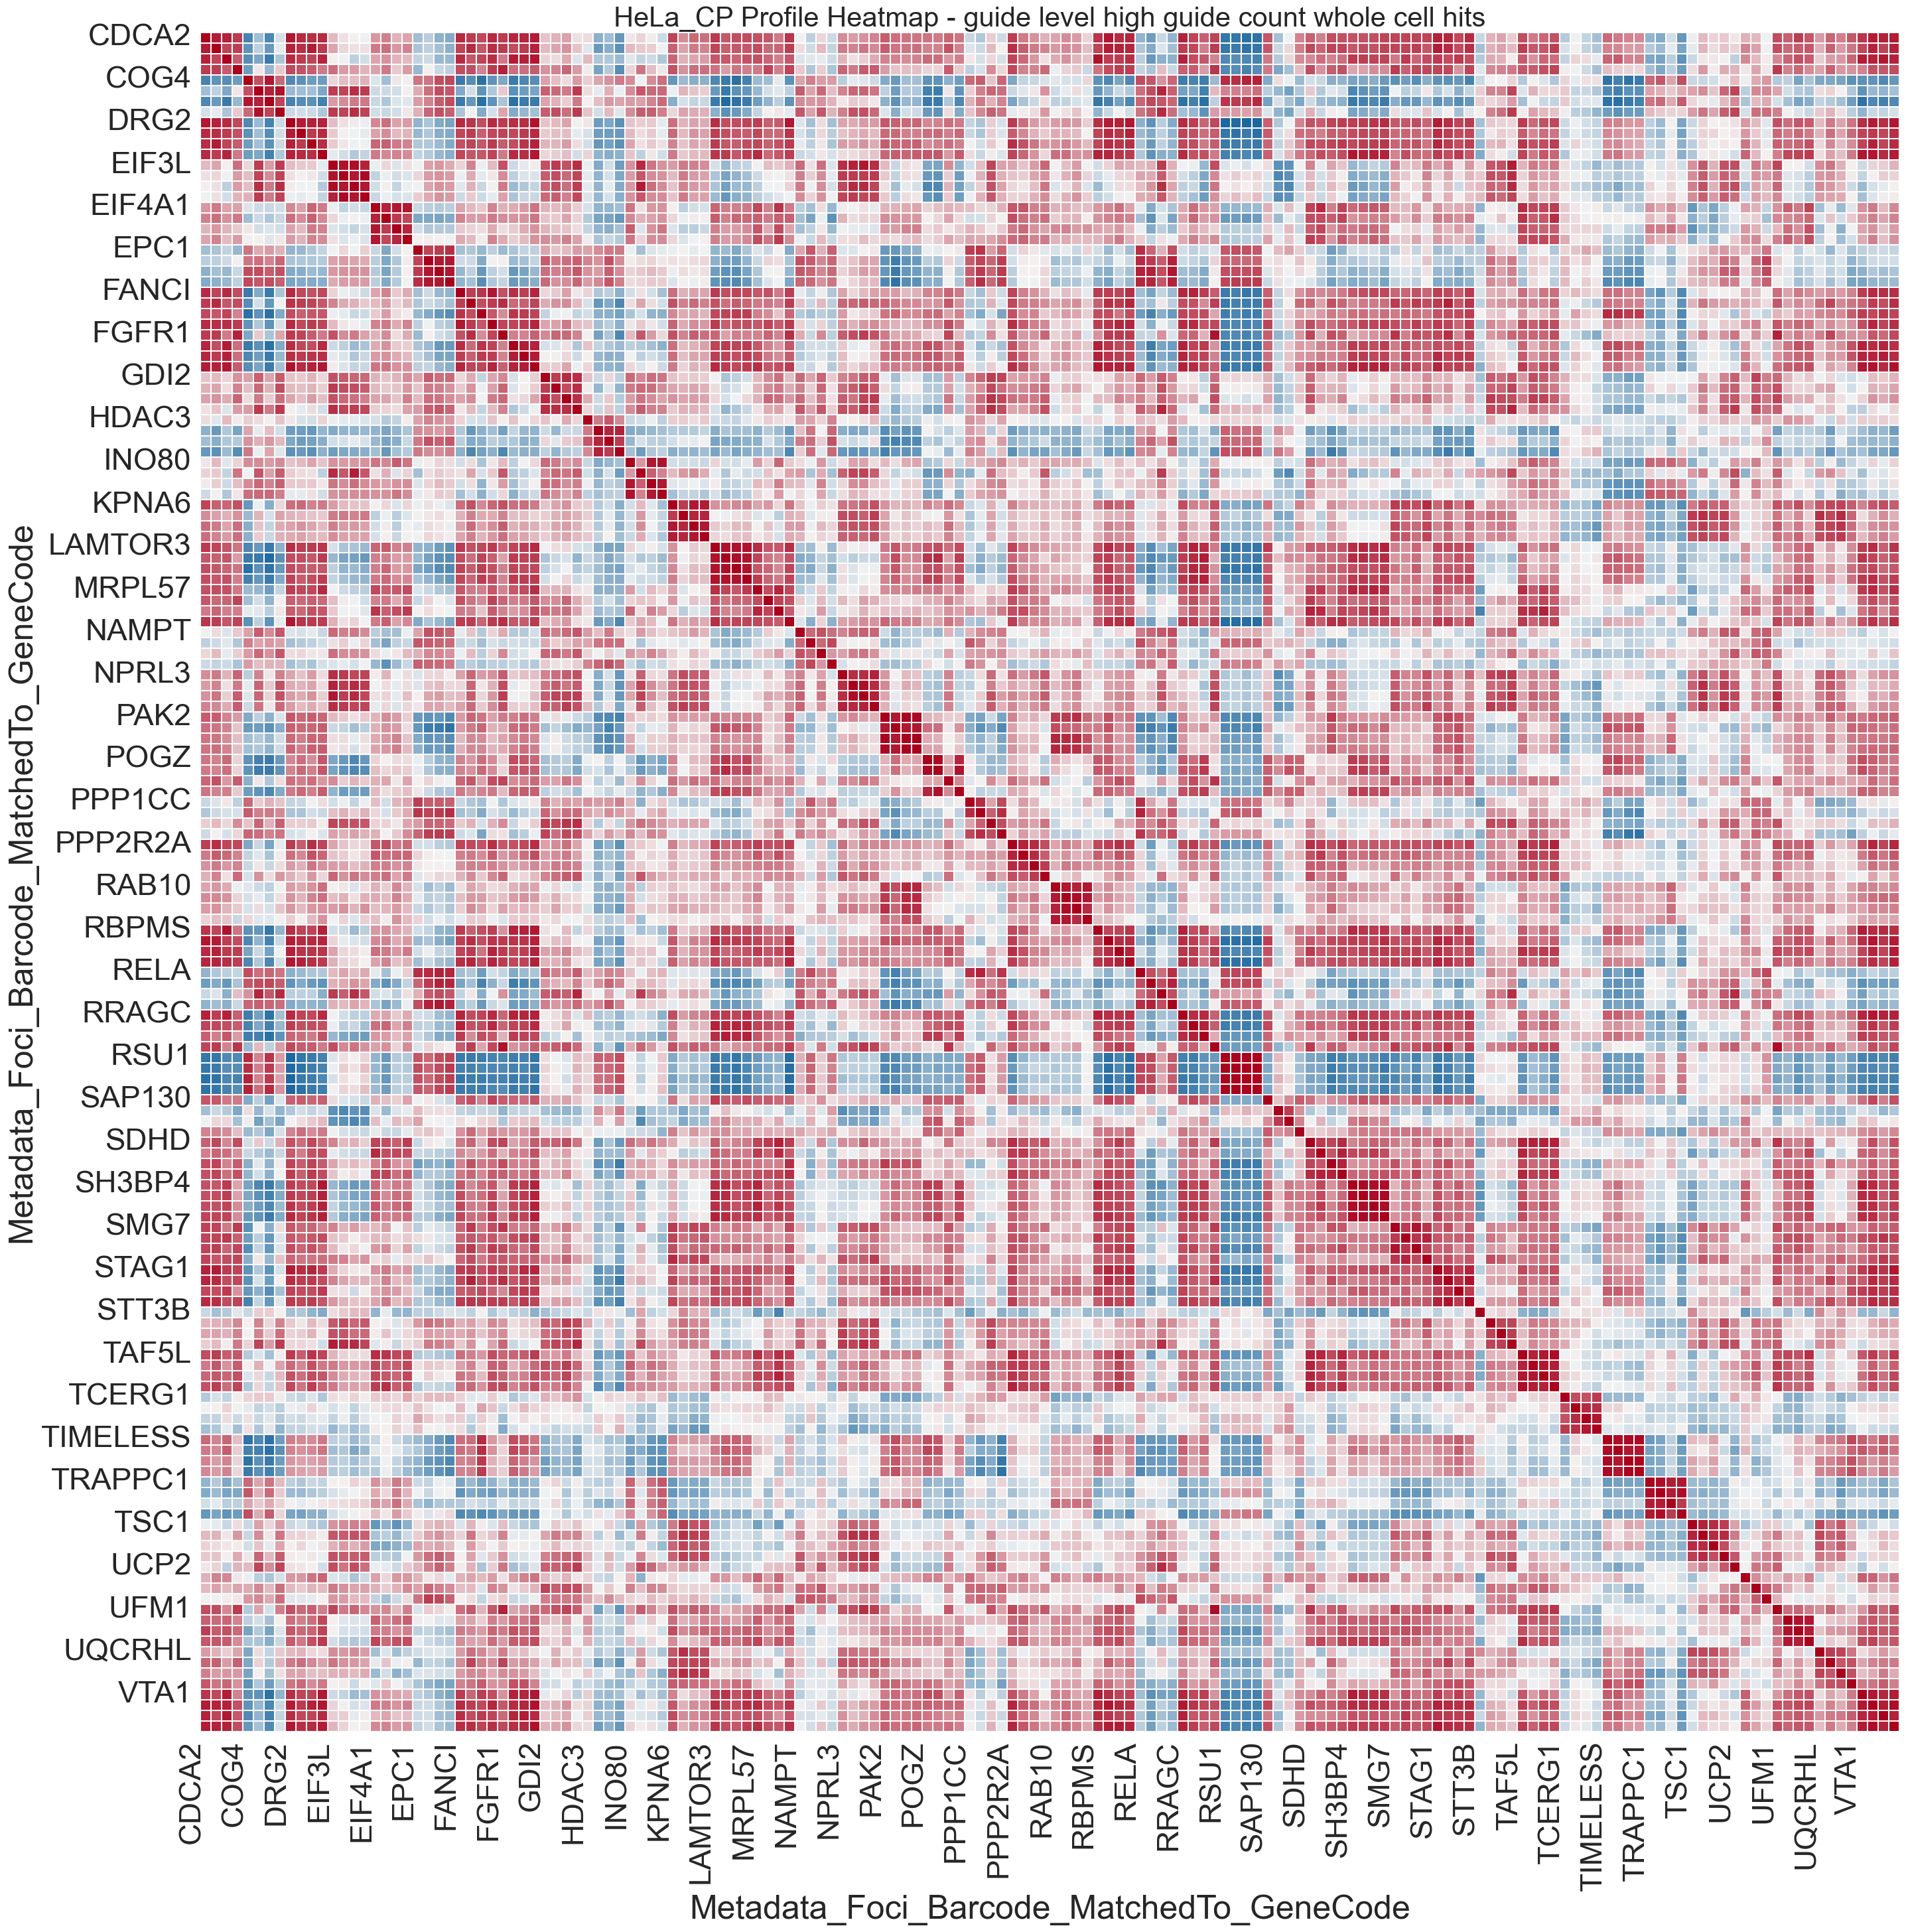

In [11]:
# find a cell count per guide to determine highly represented guides for each data set
for guide_count in range(50,1000,1): # adjust the range based on the cell count data
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(list(whole_cell_hits.Gene))]
    hit_counts = hit_counts.query(f"Cell_Count > {guide_count}").groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    high_guide_list = list(hit_counts.query("Cell_Count > 3").index)
    if len(high_guide_list) <= 50:
        guide_count = guide_count-1
        break

# Subset the data and draw heat-maps for guides with high guide count
def draw_high_count_heat_maps(counts, guide_count, hit_list, profile_df, data_set, font_scale):
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
    hit_counts = hit_counts.query(f"Cell_Count > {guide_count}").groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    high_guide_list = list(hit_counts.query("Cell_Count > 3").index)
    random.seed(13)
    genes_list = sample(high_guide_list,40)
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level high guide count whole cell hits',
                       f'{data_set}_profile_heatmap_guide_level_high_guide_count_whole_cell_hits.png',
                       font_scale)
    

draw_high_count_heat_maps(counts, guide_count, list(whole_cell_hits.Gene), pca_cell_df, 'HeLa_CP', 3)


In [ ]:
# Subset the data and draw heat-maps for guides with high guide count
def draw_high_count_heat_maps(counts, hit_list, profile_df, data_set, font_scale):
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
    df = hit_counts.groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    geneswith4guides = df.loc[df['Metadata_Foci_Barcode_MatchedTo_Barcode']==4].index.to_list()
    #print(df.loc[df['Metadata_Foci_Barcode_MatchedTo_Barcode']==4])
    hit_counts_with4guides = hit_counts.loc[hit_counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(geneswith4guides)]
    print(hit_counts_with4guides)
    Top50_barcodes = hit_counts_with4guides.groupby('Metadata_Foci_Barcode_MatchedTo_Barcode').sum(numeric_only=True).nlargest(50,'Cell_Count').index.to_list()
    #print(Top50_barcodes)
    genes_list = hit_counts_with4guides.loc[hit_counts_with4guides['Metadata_Foci_Barcode_MatchedTo_Barcode'].isin(Top50_barcodes)]['Metadata_Foci_Barcode_MatchedTo_GeneCode'].to_list()
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - Highest Cell Count Hits (guide level)',
                       f'{data_set}_profile_heatmap_guide_level_highest_cell_count_hits.png',
                       font_scale)
    
draw_high_count_heat_maps(A549_counts, A549_hit_list, A549_pca_df, 'A549', 2.7)
draw_high_count_heat_maps(DMEM_counts, DMEM_hit_list, DMEM_pca_df, 'HeLa_DMEM', 2.7)
draw_high_count_heat_maps(HPLM_counts, HPLM_hit_list, HPLM_pca_df, 'HeLa_HPLM', 2.7)

In [ ]:
# Subset the data and draw heat-maps for guides with high signal
def draw_top_heat_maps(all_hits_df, profile_df, n_top, data_set, font_scale):
    for i in range(int(all_hits_df.Sum.max()),0,-1):
        genes_lst = list(all_hits_df.query(f"Sum > {i} ").Gene)
        if len(genes_lst) >= n_top:
            break
    print(f'{len(genes_lst)} genes {data_set} dataset')
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_lst)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level Top {n_top} hits',
                       f'{data_set}_profile_heatmap_guide_level_top_{n_top}_hits.png',
                       2.7)
    
draw_top_heat_maps(A549_all_hits, A549_pca_df, 50, 'A549', 2.7)
draw_top_heat_maps(DMEM_all_hits, DMEM_pca_df, 50, 'HeLa_DMEM', 2.7)
draw_top_heat_maps(HPLM_all_hits, HPLM_pca_df, 50, 'HeLa_HPLM', 2.7)


In [ ]:
# Subset the data and draw heat-maps for guides from common hit list
def draw_functional_heat_maps(gene_set, genes_lst, profile_df, data_set, font_scale):
    
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_lst)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level {gene_set} hits',
                       f'{data_set}_profile_heatmap_guide_level_{gene_set}_hits.png',
                       2.7)
    
gene_set = 'Random 50 common hits'
common_hits = [i for i in A549_hit_list if i in DMEM_hit_list and i in HPLM_hit_list]
random.seed(10) 
random_common_hits = sample(common_hits,50)
draw_functional_heat_maps(gene_set, random_common_hits, A549_pca_df, 'A549', 2.7)
draw_functional_heat_maps(gene_set, random_common_hits, DMEM_pca_df, 'HeLa_DMEM', 2.7)
draw_functional_heat_maps(gene_set, random_common_hits, HPLM_pca_df, 'HeLa_HPLM', 2.7)


